# Predict future revenue Growth Rate - curate data and first look at models

purpose:
- clean data and build model for future growth 

In [1]:
# import libraries
import pandas as pd
import os
import numpy as np

from sklearn.preprocessing import StandardScaler

import pickle

In [2]:
# create directory to store tuning results
output_relative_dirs = ['../models/growth_standardiser/sum_transactions', '../models/growth_standardiser/number_of_customers', 
    '../models/growth_standardiser/distinct_customers', '../models/growth']

# check if it exists as it makedir will raise an error if it does exist
for output_relative_dir in output_relative_dirs:
    if not os.path.exists(output_relative_dir):
        os.makedirs(output_relative_dir)

In [6]:
# read data
growth = pd.read_csv('../data/curated/final_model/input/fortnightly_agg_merchant_transactions_NOTAKE_NOFRAUD.csv')

In [7]:
growth

,Year,Fortnight,merchant_abn,sum_transactions,number_of_customers,distinct_customers
0,2021,5,10023283211,11068.431981,50,50
1,2021,6,10023283211,10333.463549,47,47
2,2021,7,10023283211,12417.540417,56,56
3,2021,8,10023283211,14616.749734,67,67
4,2021,9,10023283211,12939.826183,63,63
...,...,...,...,...,...,...
162704,2022,12,99990536339,0.000000,0,0
162705,2022,13,99990536339,0.000000,0,0
162706,2022,14,99990536339,0.000000,0,0
162707,2022,15,99990536339,942.464109,1,1


## Standardisation

In [8]:
growth_standardised = pd.DataFrame()

for id, dta in growth.groupby(['merchant_abn']):
    
    # fit the StandardScaler using train model
    SS1 = StandardScaler()
    SS1.fit(dta[['sum_transactions']])

    dta['sum_transactions_STD'] = SS1.transform(dta[['sum_transactions']])
    
    SS2 = StandardScaler()
    SS2.fit(dta[['number_of_customers']])

    dta['number_of_customers_STD'] = SS2.transform(dta[['number_of_customers']])

    SS3 = StandardScaler()
    SS3.fit(dta[['distinct_customers']])

    dta['distinct_customers_STD'] = SS3.transform(dta[['distinct_customers']])

    growth_standardised = pd.concat([growth_standardised, dta])

    # export the model
    with open(f'../models/growth_standardiser/sum_transactions/{id}.pickle', 'wb') as f:
        pickle.dump(SS1,f)
    with open(f'../models/growth_standardiser/number_of_customers/{id}.pickle', 'wb') as f:
        pickle.dump(SS2,f)
    with open(f'../models/growth_standardiser/distinct_customers/{id}.pickle', 'wb') as f:
        pickle.dump(SS3,f)

In [10]:
# drop unstandardised columns
growth_standardised = growth_standardised.drop(['sum_transactions', 'number_of_customers', 'distinct_customers'], axis=1)

## Create label of 1) delta (internally standardised transaction value) and 2) next period internally standardised transaction value

In [6]:
merchant_fortnight_w_deltachange = pd.DataFrame()

for id, dta in growth_standardised.groupby(['merchant_abn']):
    dta['delta(r)'] = dta['sum_transactions_STD'].diff(1)
    dta['delta(n_customers)'] = dta['number_of_customers_STD'].diff(1)
    dta['delta(distinct_customers)'] = dta['distinct_customers_STD'].diff(1)
    
    label1 = list(dta['delta(r)'])[1:]
    label1.append(None)

    label2 = list(dta['delta(n_customers)'])[1:]
    label2.append(None)

    label3 = list(dta['delta(distinct_customers)'])[1:]
    label3.append(None)

    dta['label1'] = label1
    dta['label2'] = label2
    dta['label3'] = label3

    merchant_fortnight_w_deltachange = merchant_fortnight_w_deltachange.append(dta)

merchant_fortnight_w_deltachange

,Year,Fortnight,merchant_abn,sum_transactions_STD,number_of_customers_STD,distinct_customers_STD,delta(r),delta(n_customers),delta(distinct_customers),label1,label2,label3
0,2021,5,10023283211,-1.112007,-1.348704,-1.345017,NaN,NaN,NaN,-0.183912,-0.180700,-0.180909
1,2021,6,10023283211,-1.295918,-1.529404,-1.525925,-0.183912,-0.180700,-0.180909,0.521500,0.542100,0.542726
2,2021,7,10023283211,-0.774419,-0.987303,-0.983199,0.521500,0.542100,0.542726,0.550309,0.662567,0.663332
3,2021,8,10023283211,-0.224109,-0.324736,-0.319868,0.550309,0.662567,0.663332,-0.419617,-0.240933,-0.241212
4,2021,9,10023283211,-0.643727,-0.565670,-0.561079,-0.419617,-0.240933,-0.241212,0.559929,0.481867,0.482423
...,...,...,...,...,...,...,...,...,...,...,...,...
97174,2021,23,99990536339,-0.726769,-1.135860,-1.135860,0.000000,0.000000,0.000000,3.995908,2.538982,2.538982
97175,2021,24,99990536339,3.269139,1.403122,1.403122,3.995908,2.538982,2.538982,-3.995908,-2.538982,-2.538982
97176,2021,25,99990536339,-0.726769,-1.135860,-1.135860,-3.995908,-2.538982,-2.538982,0.264744,1.269491,1.269491
97177,2021,26,99990536339,-0.462025,0.133631,0.133631,0.264744,1.269491,1.269491,-0.264744,-1.269491,-1.269491


In [7]:
# drop original useless columns
merchant_fortnight_w_deltachange = merchant_fortnight_w_deltachange.drop(['delta(r)', 'delta(n_customers)',
    'delta(distinct_customers)'], axis=1)
merchant_fortnight_w_deltachange

,Year,Fortnight,merchant_abn,sum_transactions_STD,number_of_customers_STD,distinct_customers_STD,label1,label2,label3
0,2021,5,10023283211,-1.112007,-1.348704,-1.345017,-0.183912,-0.180700,-0.180909
1,2021,6,10023283211,-1.295918,-1.529404,-1.525925,0.521500,0.542100,0.542726
2,2021,7,10023283211,-0.774419,-0.987303,-0.983199,0.550309,0.662567,0.663332
3,2021,8,10023283211,-0.224109,-0.324736,-0.319868,-0.419617,-0.240933,-0.241212
4,2021,9,10023283211,-0.643727,-0.565670,-0.561079,0.559929,0.481867,0.482423
...,...,...,...,...,...,...,...,...,...
97174,2021,23,99990536339,-0.726769,-1.135860,-1.135860,3.995908,2.538982,2.538982
97175,2021,24,99990536339,3.269139,1.403122,1.403122,-3.995908,-2.538982,-2.538982
97176,2021,25,99990536339,-0.726769,-1.135860,-1.135860,0.264744,1.269491,1.269491
97177,2021,26,99990536339,-0.462025,0.133631,0.133631,-0.264744,-1.269491,-1.269491


In [8]:
# drop last row of each company because of NaN label (from label creatino process)
merchant_fortnight_w_deltachange = merchant_fortnight_w_deltachange.dropna()

## Get the lags for time series analysis

In [9]:
# create lags
growth_standardised_timeSeries = pd.DataFrame()

for id, dta in merchant_fortnight_w_deltachange.groupby(['merchant_abn']):

    for i in range(1, 6):
        dta[f'sum_transactions_STD_t-{i}'] = dta['sum_transactions_STD'].shift(i)
        dta[f'number_of_customers_STD_t-{i}'] = dta['number_of_customers_STD'].shift(i)
        dta[f'distinct_customers_STD_t-{i}'] = dta['distinct_customers_STD'].shift(i)
    
    growth_standardised_timeSeries = pd.concat([growth_standardised_timeSeries, dta])

In [10]:
# rename original columns with t-0
growth_standardised_timeSeries = growth_standardised_timeSeries.rename(columns={'sum_transactions_STD': 'sum_transactions_STD_t-0', 'number_of_customers_STD': 'number_of_customers_STD_t-0', 'distinct_customers_STD': 'distinct_customers_STD_t-0'})

Add in persona data

In [13]:
# do train val test split
train_standardised = growth_standardised_timeSeries[(growth_standardised_timeSeries['Year'] == 2021) & (growth_standardised_timeSeries['Fortnight'] < 21)]

val_standardised = growth_standardised_timeSeries[(growth_standardised_timeSeries['Year'] == 2021) & ((growth_standardised_timeSeries['Fortnight'] >= 21) & (growth_standardised_timeSeries['Fortnight'] <= 24))]

test_standardised = growth_standardised_timeSeries[(growth_standardised_timeSeries['Year'] == 2022) | ((growth_standardised_timeSeries['Year'] == 2021) & (growth_standardised_timeSeries['Fortnight'] > 24))]

### Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression

label 1's feature selection

In [15]:
# select k best
selectk_F1 = SelectKBest(f_regression, k = len(train_standardised.columns) - 6)

# because of time series analysis, some rows have nan attribute values. Even though might be using t-1 or t-2 as time series analysis,
# still drop as if using t-5 for simplicity sake
train_standardised_dropna = train_standardised.dropna() 
val_standardised_dropna = val_standardised.dropna()
test_standardised_dropna = test_standardised.dropna()

selectk_F1.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label1'])

SelectKBest(k=18, score_func=<function f_regression at 0x7f91c970a1f0>)

In [16]:
# get the ranked feature names and scores
kbest_scores1 = pd.DataFrame({'features': selectk_F1.get_feature_names_out(), 'scores': selectk_F1.scores_})
kbest_scores1 = kbest_scores1.sort_values('scores', ascending=False)
kbest_scores1

,features,scores
0,sum_transactions_STD_t-0,46583.953058
1,number_of_customers_STD_t-0,22608.632960
2,distinct_customers_STD_t-0,22601.135039
15,sum_transactions_STD_t-5,1.246396
9,sum_transactions_STD_t-3,0.725416
13,number_of_customers_STD_t-4,0.355538
14,distinct_customers_STD_t-4,0.352036
3,sum_transactions_STD_t-1,0.336616
16,number_of_customers_STD_t-5,0.265042
17,distinct_customers_STD_t-5,0.263849


label 2's feature selection

In [17]:
# select k best
selectk_F2 = SelectKBest(f_regression, k=len(train_standardised.columns) - 6)

train_standardised_dropna = train_standardised.dropna()
val_standardised_dropna = val_standardised.dropna()
test_standardised_dropna = test_standardised.dropna()

selectk_F2.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label2'])

SelectKBest(k=18, score_func=<function f_regression at 0x7f91c970a1f0>)

In [18]:
# get the ranked feature names and scores
kbest_scores2 = pd.DataFrame({'features': selectk_F2.get_feature_names_out(), 'scores': selectk_F2.scores_})
kbest_scores2 = kbest_scores2.sort_values('scores', ascending=False)
kbest_scores2

,features,scores
1,number_of_customers_STD_t-0,4.585030e+04
2,distinct_customers_STD_t-0,4.583425e+04
0,sum_transactions_STD_t-0,2.315627e+04
6,sum_transactions_STD_t-2,1.615359e+00
9,sum_transactions_STD_t-3,1.017126e+00
8,distinct_customers_STD_t-2,1.009561e+00
7,number_of_customers_STD_t-2,9.782430e-01
11,distinct_customers_STD_t-3,5.453578e-01
10,number_of_customers_STD_t-3,5.353369e-01
3,sum_transactions_STD_t-1,1.756624e-01


label 3's feature selection

In [19]:
# select k best
selectk_F3 = SelectKBest(f_regression, k=len(train_standardised.columns) - 6)

train_standardised_dropna = train_standardised.dropna()
val_standardised_dropna = val_standardised.dropna()
test_standardised_dropna = test_standardised.dropna()

selectk_F3.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label3'])

SelectKBest(k=18, score_func=<function f_regression at 0x7f91c970a1f0>)

In [20]:
# get the ranked feature names and scores
kbest_scores3 = pd.DataFrame({'features': selectk_F3.get_feature_names_out(), 'scores': selectk_F3.scores_})
kbest_scores3 = kbest_scores3.sort_values('scores', ascending=False)
kbest_scores3

,features,scores
2,distinct_customers_STD_t-0,45849.106515
1,number_of_customers_STD_t-0,45818.785595
0,sum_transactions_STD_t-0,23147.481490
6,sum_transactions_STD_t-2,1.602325
9,sum_transactions_STD_t-3,1.010923
8,distinct_customers_STD_t-2,1.005485
7,number_of_customers_STD_t-2,0.974796
11,distinct_customers_STD_t-3,0.532803
10,number_of_customers_STD_t-3,0.523366
3,sum_transactions_STD_t-1,0.174393


## Plotting

In [21]:
import matplotlib.pyplot as plt

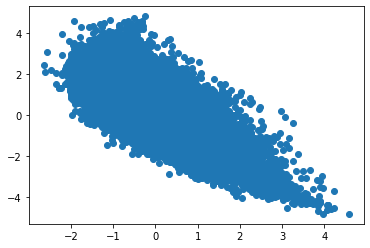

In [22]:
plt.scatter(train_standardised_dropna['sum_transactions_STD_t-0'], train_standardised_dropna['label1'])

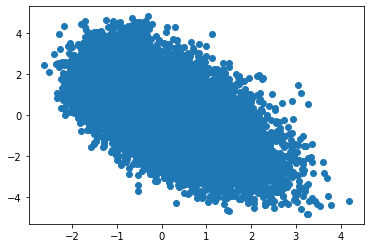

In [23]:
plt.scatter(train_standardised_dropna['number_of_customers_STD_t-0'], train_standardised_dropna['label1'])

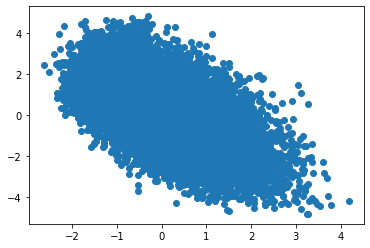

In [24]:
plt.scatter(train_standardised_dropna['distinct_customers_STD_t-0'], train_standardised_dropna['label1'])

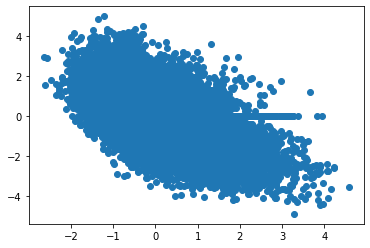

In [25]:
plt.scatter(train_standardised_dropna['sum_transactions_STD_t-0'], train_standardised_dropna['label2'])

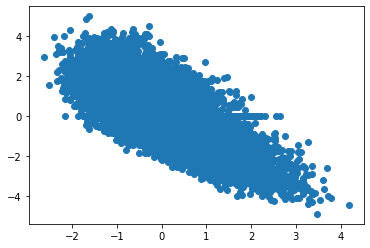

In [26]:
plt.scatter(train_standardised_dropna['number_of_customers_STD_t-0'], train_standardised_dropna['label2'])

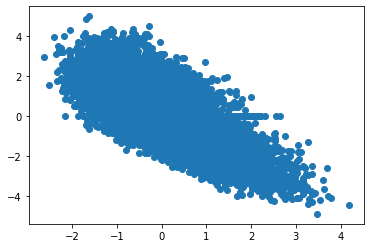

In [27]:
plt.scatter(train_standardised_dropna['distinct_customers_STD_t-0'], train_standardised_dropna['label2'])

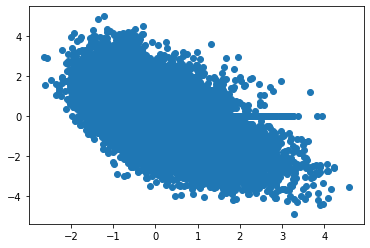

In [28]:
plt.scatter(train_standardised_dropna['sum_transactions_STD_t-0'], train_standardised_dropna['label3'])

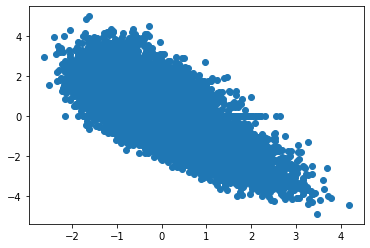

In [29]:
plt.scatter(train_standardised_dropna['number_of_customers_STD_t-0'], train_standardised_dropna['label3'])

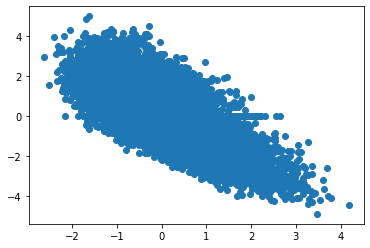

In [30]:
plt.scatter(train_standardised_dropna['distinct_customers_STD_t-0'], train_standardised_dropna['label3'])

# Models
### 1. Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

label1

In [32]:
LR = LinearRegression()
LR.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

LinearRegression()

In [33]:
predictions = LR.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.030275
std,0.805496
min,-4.795080
25%,-0.372863
50%,0.160314
75%,0.567405
max,2.582606


In [34]:
LR.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

0.5077145072399425

In [36]:
LR.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label1'])

0.4726485719503615

In [37]:
# export the model
with open(f'../models/growth/delta_revenue.pickle', 'wb') as f:
    pickle.dump(LR,f)

label 2

In [38]:
LR2 = LinearRegression()
LR2.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label2'])

LinearRegression()

In [39]:
predictions = LR2.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.033391
std,0.765745
min,-4.360214
25%,-0.361873
50%,0.120436
75%,0.536614
max,2.558694


In [40]:
LR2.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label2'])

0.5036491645569431

In [42]:
LR2.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label2'])

0.44452384140518997

In [43]:
# export the model
with open(f'../models/growth/delta_number_of_customers.pickle', 'wb') as f:
    pickle.dump(LR,f)

label 3

In [44]:
LR3 = LinearRegression()
LR3.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label3'])

LinearRegression()

In [45]:
predictions = LR3.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.033430
std,0.765931
min,-4.359816
25%,-0.363018
50%,0.119359
75%,0.536842
max,2.558856


In [46]:
LR3.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label3'])

0.5036432964505824

In [48]:
LR3.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label3'])

0.44376133428026776

In [49]:
# export the model
with open(f'../models/growth/delta_distinct_customers.pickle', 'wb') as f:
    pickle.dump(LR,f)

### 2. XGBoost 

In [50]:
import xgboost

label 1

In [51]:
m1 = xgboost.XGBRegressor()
m1.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [52]:
predictions = m1.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.030242
std,0.817589
min,-4.606647
25%,-0.379073
50%,0.121023
75%,0.555509
max,3.511868


In [53]:
m1.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

0.568289779909569

In [54]:
m1.score(val_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], val_standardised_dropna['label1'])

-0.05864081019149925

In [55]:
m1.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label1'])

0.45497041017788875

label 2

In [56]:
m2 = xgboost.XGBRegressor()
m2.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label2'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [57]:
predictions = m2.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.033330
std,0.776493
min,-4.582758
25%,-0.374490
50%,0.096399
75%,0.532144
max,3.499539


In [58]:
m2.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label2'])

0.5593806827170784

In [59]:
m2.score(val_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], val_standardised_dropna['label2'])

-0.18614389850020907

In [60]:
m2.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label2'])

0.4294199963417994

label 3

In [61]:
m3 = xgboost.XGBRegressor()
m3.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label3'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [62]:
predictions = m3.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.033405
std,0.777631
min,-4.365232
25%,-0.370116
50%,0.095245
75%,0.548549
max,3.458809


In [63]:
m3.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label3'])

0.5648871053285667

In [64]:
m3.score(val_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], val_standardised_dropna['label3'])

-0.18035532414327293

In [65]:
m3.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label3'])

0.42548968873077986

### 3. Random Forest Regression



In [66]:
from sklearn.ensemble import RandomForestRegressor

label 1

In [67]:
RFR = RandomForestRegressor()
RFR.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label1'])

RandomForestRegressor()

In [68]:
RFR.score(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label1'])

0.9243286546946009

In [69]:
RFR.score(val_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), val_standardised_dropna['label1'])

-0.028299582813162028

In [70]:
RFR.score(test_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), test_standardised_dropna['label1'])

0.4511835633164608

label 2

In [71]:
RFR2 = RandomForestRegressor()
RFR2.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label2'])

RandomForestRegressor()

In [72]:
RFR2.score(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label2'])

0.9221277403951377

In [73]:
RFR2.score(val_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), val_standardised_dropna['label2'])

-0.195905629457507

In [74]:
RFR2.score(test_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), test_standardised_dropna['label2'])

0.4180385729553956

label 3

In [75]:
RFR3 = RandomForestRegressor()
RFR3.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label1'])

RandomForestRegressor()

In [76]:
RFR3.score(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), train_standardised_dropna['label3'])

0.612446212176351

In [77]:
RFR3.score(val_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), val_standardised_dropna['label3'])

-0.17871235972469668

In [78]:
RFR3.score(test_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2', 'label3'], axis=1), test_standardised_dropna['label3'])

0.23575093840559458